In [64]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the ticker symbol
ticker = "AAPL"

In [65]:
data = yf.download(ticker,start="2018-01-01",end="2023-10-31")

[*********************100%***********************]  1 of 1 completed


In [66]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.524338,40.533750,39.818585,40.030313,102223600
2018-01-03,40.517284,41.063069,40.453769,40.587860,118071600
2018-01-04,40.705490,40.809001,40.482002,40.590216,89738400
2018-01-05,41.168926,41.255968,40.710187,40.801935,94640000
2018-01-08,41.016018,41.312433,40.917209,41.016018,82271200


In [67]:
data.to_csv('data.csv', index=False)

In [68]:
data = data.dropna()

In [69]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [70]:
data = pd.DataFrame(data_normalized, columns=data.columns)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [71]:
test_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1173,0.764153,0.776857,0.762417,0.784353,0.117574
1174,0.753784,0.764777,0.758833,0.773141,0.143102
1175,0.758324,0.751600,0.743572,0.750534,0.108269
1176,0.745132,0.763435,0.745426,0.769692,0.115174
1177,0.737279,0.743486,0.737518,0.749487,0.106965


In [72]:
from stable_baselines3 import PPO

import gym

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance = 100000  # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step > len(self.data) - 1:
            self.current_step = 0

        return self._next_observation(), self._get_reward(), self.net_worth, {}

    def _take_action(self, action):
        if action == 0:  # Buy
            self.shares_held += self.account_balance / self.data.iloc[self.current_step].values[0]
            self.account_balance -= self.account_balance
        elif action == 1:  # Sell
            self.account_balance += self.shares_held * self.data.iloc[self.current_step].values[0]
            self.shares_held -= self.shares_held

        self.net_worth = self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0]

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):
        return self.net_worth - self.account_balance

# Create the trading environment
env = TradingEnvironment(train_data)

In [78]:
model = PPO("MlpPolicy", env, verbose=1,device="cpu")

# Train the model
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 3.1e+04  |
| time/              |          |
|    fps             | 2063     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1             |
|    ep_rew_mean          | 3.6e+04       |
| time/                   |               |
|    fps                  | 1588          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 5.8778154e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0             |


In [79]:
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data)
    obs = env.reset()

    for i in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, _, _ = env.step(action)

    return env.net_worth

In [80]:
net_worth = simulate_trading_strategy(model, test_data)
from stable_baselines3 import PPO
from stable_baselines3.common.envs import DummyVecEnv


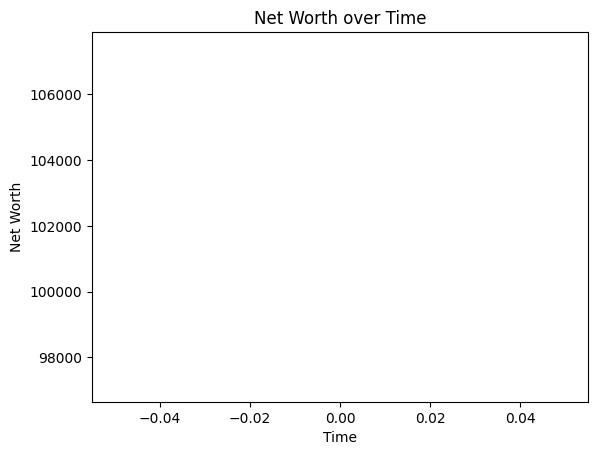

In [81]:
import matplotlib.pyplot as plt


# Plot the net worth over time
plt.plot(net_worth,color='red')
plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time")
plt.show()

In [77]:
print(net_worth)

150228.7232748401
